In [107]:
import numpy as np
import itertools
from itertools import combinations
from itertools import permutations
import math
#from timeit import default_timer as timer
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['legend.loc'] = 'best'
import scipy
import scipy.stats as stat
import random
NUM_PAIRS=5
#pylab inline


In [5]:
# support classes and methods
class Doc:
    click=None
    clickProb=None
    def __init__(self,label,team,click=0):
        self.label=label
        self.team=team
def readClickAndQueries(file):
    #clicks=[]
    queries=[]
    sessionIDClicks=dict()
    with open(file) as f:
            for sentence in f:
                parts = sentence.split('\t')
                if(parts[2]=="C"):
                    sessionID=parts[0].strip()
                    #click=Click(sessionID=parts[0],timePassed=parts[1],typeOfAction=parts[2],urlID=parts[3])
                    click=parts[3].strip()
                    #clicks.append(click)
                    if(sessionID not in sessionIDClicks):
                        sessionIDClicks[sessionID]=[]
                    sessionIDClicks[sessionID].append(click)

                else:
                    urls=[]
                    for i in range(5,len(parts)):
                        urls.append(parts[i].strip())
                    queries.append(Query(sessionID=parts[0],timePassed=parts[1],typeOfAction=parts[2],queryID=parts[3],regionID=parts[4],listOfURLs=urls))
    return sessionIDClicks,queries,

class Click:
    def __init__(self,sessionID,timePassed,typeOfAction,urlID):
        self.sessionID=sessionID
        self.timePassed=timePassed
        self.typeOfAction=typeOfAction
        self.urlID=urlID

class Query:
     def __init__(self,sessionID,timePassed,typeOfAction,queryID,regionID,listOfURLs):
        self.sessionID=sessionID
        self.timePassed=timePassed
        self.typeOfAction=typeOfAction
        self.queryID=queryID
        self.regionID=regionID
        self.listOfURLs=listOfURLs

<h1>Step1</h1>

In [6]:
# this methods generates pairs of length 5
# r: max number in each element.
def generatePairs(r):
    items=range(r)
    res=[]
    for p in itertools.product(items, repeat=5):
        for e in itertools.product(items, repeat=5):
            res.append([p,e])
    print("generated "+str(len(res))+" pairs")
    return res

In [19]:
# test:
pairs=generatePairs(NUM_PAIRS)
print(pairs)

generated 59049 pairs


<h1>Step2</h1>

In [117]:
def DCG(inst):
    res=0
    for r in range(1,len(inst)+1):
        res+=(math.pow(2,(inst[r-1])) -1)\
             /(math.log(1+r,2))
    return res

def ERR(inst):
    res=0
    prod=1
    for r in range(len(inst)):
        R=normRel(inst[r])
        res+=prod*R/(r+1)
        prod*=1-R
    return res

def RBP(inst):
    p = 0.8
    res=0
    for r in range(len(inst)):
        res+=inst[r]*math.pow(p,r)
    return (1-p)*res

def normRel(rel,max=4):
    return (math.pow(2,rel)-1)/math.pow(2,max)

def measureAndGroup(pairs):
    groups={
                'DCG':[],
                'RBP':[],
                'ERR':[]
            }

    DCGmin=99999999
    DCGmax=-99999999

    RBPmin=99999999
    RBPmax=-99999999


    for i in range(0,10):
        groups['DCG'].append([])
        groups['RBP'].append([])
        groups['ERR'].append([])


    for pair in pairs:
        p1=pair[0] # producton (P)
        p2=pair[1] # experimental (E)

        DCG1=DCG(p1)
        DCG2=DCG(p2)

        RBP1=RBP(p1)
        RBP2=RBP(p2)

        ERR1= ERR(p1)
        ERR2= ERR(p2)


        deltaDCG= DCG2-DCG1
        deltaRBP= RBP2-RBP1
        deltaERR=ERR2-ERR1

        pair.append({
            "deltaDCG":deltaDCG,
            "deltaRBP":deltaRBP,
            "deltaERR":deltaERR
        })


        # storing info about min/max

        if(deltaDCG>DCGmax and deltaDCG>0):
            DCGmax=deltaDCG
        if(deltaDCG<DCGmin and deltaDCG>0):
            DCGmin=deltaDCG

        if(deltaRBP>RBPmax and deltaRBP>0):
            RBPmax=deltaRBP
        if(deltaRBP<RBPmin and deltaRBP>0):
            RBPmin=deltaRBP


    # grouping
    binDCG=(DCGmax-DCGmin)/10
    binRBP=(RBPmax-RBPmin)/10
    binERR=0.1

    for pair in pairs:
        measures = pair[2]

        DCGgr= int( math.floor(measures['deltaDCG']/binDCG))
        RBPgr= int(math.floor(measures['deltaRBP']/binRBP))
        ERRgr= int(math.floor(measures['deltaERR']/binERR))

        if(DCGgr==10): DCGgr-=1
        if(RBPgr==10): RBPgr-=1
        if(ERRgr==10): ERRgr-=1

        tuple=(pair[0],pair[1])

        if measures['deltaDCG']>0:
            groups['DCG'][DCGgr].append(tuple)
        if measures['deltaRBP']>0:
            groups['RBP'][RBPgr].append(tuple)
        if measures['deltaERR']>0:
            groups['ERR'][ERRgr].append(tuple)
    return groups

def plotBins(bins):
    ind = np.arange(10)
    dcg_bin_count = [len(bins['DCG'][i]) for i in range(10)]
    rbp_bin_count = [len(bins['RBP'][i]) for i in range(10)]
    err_bin_count = [len(bins['ERR'][i]) for i in range(10)]
    width = 0.2
    fig, ax = plt.subplots()
    rects1 = ax.bar(ind, dcg_bin_count, width, color='r', label='DCG')
    rects2 = ax.bar(ind + width, rbp_bin_count, width, color='g', label='RBP')
    rects3 = ax.bar(ind + 2 * width, err_bin_count, width, color='b', label='ERR')

    plt.grid(True)
    plt.legend()

    plt.show()

for seq: [4, 4, 4, 4, 4]
DCG is: 44.2268867832
ERR is: 0.968077659607
RBP is: 2.68928
generated 9765625 pairs


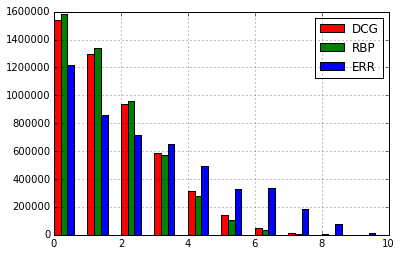

In [118]:
## test
seq =[4,4,4,4,4]
print("for seq: "+ str(seq))
print("DCG is: "+ str(DCG(seq)))
print("ERR is: "+ str(ERR(seq)))
print("RBP is: "+ str(RBP(seq)))


pairs=generatePairs(NUM_PAIRS)
groups= measureAndGroup(pairs)
# plot the number of elements in each bin in each measure
plotBins(groups)

<h1>Step 3</h1>

In [61]:
# return an array of interleaved documents
def teamDraftInterleaving(A,B):
    I =[] # unterleaved result
    i=0
    j=0
    teamA=[]
    teamB=[]
    while (i<(len(A)) or j<(len(B))): # while not used all items
        if(len(teamA)<len(teamB) or len(teamA)==len(teamB) and random.getrandbits(1)==1):
            if(i==len(A)): continue; # used all items in A
            I.append(Doc(label=A[i],team="A")) # appending an object
            teamA.append(A[i])
            i+=1
        else:
            if(j==len(B)): continue; # used all items in B
            I.append(Doc(label=B[j],team="B")) # appending an object
            teamB.append(B[j])
            j+=1
    return I

In [77]:
# test
A=[1,2,3,4,5]
B=[6,7,8,9,10]
I= teamDraftInterleaving(A,B)

for el in I:
    print(str(el.label)+' from team '+str(el.team))

# or more sophisticated test
pairs=generatePairs(NUM_PAIRS)
groups= measureAndGroup(pairs)
InterL ={'DCG':[],'RBP':[],'ERR':[]}
for i in range(10):
    InterL['DCG'].append([])
    InterL['RBP'].append([])
    InterL['ERR'].append([])
for mes in groups:
    for bin in range(len(groups[mes])):
        for pair in groups[mes][bin]:
                InterL[mes][bin].append(teamDraftInterleaving(pair[0],pair[1]))

1 from team A
6 from team B
2 from team A
7 from team B
3 from team A
8 from team B
4 from team A
9 from team B
5 from team A
10 from team B
generated 59049 pairs


<h1>Step 4</h1>

In [95]:
class RCM:
    p = 0.5 # default probability
    def __init__(self,p=None):
        self.p= p if not p==None else self.p

    def train(self,clicks,queries):
        num_clicks=0
        num_docs=0
        for i in range(len(queries)):
            num_docs+=len(queries[i].listOfURLs)
        for key,value in clicks.items():
            num_clicks+=len(value)
        self.p=float(num_clicks)/float(num_docs)


    # computes probabilities for SERP items and sets some as clicked
    # operation on the input array
    def compProb(self,docs):
         for i in range(0,len(docs)):
            docs[i].clickProb=self.p
            docs[i].click=self.click()

    def click(self):
        if(random.uniform(0,1)<=self.p):
            return True
        else:
            return False

    # returns the scores of the experiment
    def runExper(self,docs):
        self.compProb(docs)
        A=0
        B=0
        for doc in docs:
            if doc.click==True:
                if(doc.team=='A'): A+=1
                else: B+=1
        return (A,B)

class SDCM:
    lam=None

    # n: max number of SERP items
    def __init__(self,lam=None,n=10):
        if(lam==None):
            self.lam=[]
            for i in range(n):
                self.lam.append(0.5) # 0.5 is default

    def train(self,clicks,queries):
        sat=[]
        sessions=[] # sessions where ith doc was clicked
        for i in range(10):
            sat.append(set())
            sessions.append(set())

        for q in queries:
            lastClick=None
            sessionID=q.sessionID
            l=len(q.listOfURLs)
            for i in range(10):
                if(i>=l): continue
                doc=q.listOfURLs[i]

                if(sessionID in clicks and doc in clicks[sessionID]):
                    sessions[i].add(sessionID)
                    lastClick=i

            if not lastClick==None:
                sat[lastClick].add(sessionID)   # the lastClick is rank of doc which was clicked last

        # final computation
        for i in range(10):
            if len(sat[i])==0 or len(sessions[i])==0:
                s=0
            else:
                s=float(len(sat[i]))/float(len(sessions[i]))
            self.lam[i]=1-s


    # computes probabilities for SERP items and sets some as clicked
    # operation on the input array
    def compProb(self,docs):

        prev_e=1
        for i in range(0,len(docs)):
            try:
                alpha=docs[i].label/4 # the attractiveness param.
            except TypeError:
                print(docs[i])

            e =1 # examination param

            if(i>0):
                if(docs[i-1].click==True):
                    e=self.lam[i-1]
                else:
                    prev_alpha=docs[i-1].label/4
                    e=(1-prev_alpha)*prev_e/(1-prev_alpha*prev_e)
            prev_e=e
            prob = alpha*e

            # assign click (True or False)
            # at this stage
            docs[i].click = self.click(prob)
            docs[i].clickProb=prob

    def click(self,prob):
        if(random.uniform(0,1)<=prob):
            return True
        else:
            return False

    # returns the scores of the experiment
    def runExper(self,docs):
        self.compProb(docs)
        A=0
        B=0
        for doc in docs:
            if doc.click==True:
                if(doc.team=='A'): A+=1
                else: B+=1
        return (A,B)

In [96]:
## test 
# training models

file = 'YandexRelPredChallenge.txt'
clicks,queries= readClickAndQueries(file)
rcm = RCM()
sdcm = SDCM()
rcm.train(clicks,queries)
sdcm.train(clicks,queries)

print('param of RCM is: ' +str(rcm.p))
print('params of SDCM is: ' +str(sdcm.lam))

param of RCM is: 0.13445559411
params of SDCM is: [0.24608892548373817, 0.4596477646603445, 0.49269717624148, 0.49154025670945156, 0.4819277108433735, 0.48503740648379057, 0.44308390022675737, 0.3846153846153846, 0.29679144385026734, 0.0]


<h1>Step 5</h1>

In [119]:
# returns a limited number of samples out of every bin
# this function is used to save computation resources
def samplePairs(bins,per_bin):
    samples={'DCG':[],'RBP':[],'ERR':[]}
    for mes in bins:
        for bin in bins[mes]:
            n = len(bin)
            m= per_bin if (n>=per_bin) else n # if we reach the limit of the bin
            samples[mes].append(random.sample(bin, m))
    return samples



def simulateExperiment():
    pairs=generatePairs(NUM_PAIRS)
    # now we compute bins for 3 measures from step 2
    pairs=measureAndGroup(pairs)
    # since we don't want to run experiments on all pairs, we shall do subsampling as was described in the comment on the blackboard
    # notice that we subsample from previously computed bins that had a positive delta
    bin_pairs=samplePairs(pairs,20) # from each bin we will sample 20 max pairs
    # note that bin_pairs is a hash object for 3 measures with samples from every bins
    file = 'YandexRelPredChallenge.txt'
    clicks,queries= readClickAndQueries(file)
    rcm = RCM()
    sdcm=SDCM()
    # training models
    rcm.train(clicks,queries)
    sdcm.train(clicks,queries)
    models=[rcm,sdcm]

    groups={'DCG':[],'RBP':[],'ERR':[]}
    for i in range(10):
        groups['DCG'].append([])
        groups['RBP'].append([])
        groups['ERR'].append([])

    print('Starting click simulation')
    for mes in bin_pairs:
        for bin in range(len(bin_pairs[mes])):
            for pair in bin_pairs[mes][bin]:
                # first one is P, second one is E
                I=teamDraftInterleaving(pair[0],pair[1])
                A_wins=0
                B_wins=0
                for i in range(10): # run 10 experiments with each model.
                    for model in models:
                        res=model.runExper(I)
                        if(res[0]>res[1]): A_wins+=1
                        else: B_wins+=1

                if(B_wins>A_wins): # if E won over P
                    A_prob=float(A_wins)/float(A_wins+B_wins)
                    B_prob=float(B_wins)/float(A_wins+B_wins)
                    delta=B_prob-A_prob
                    # storing delta, and both probabilities to avoid re-computation later on.
                    groups[mes][bin].append({'pair':pair,'delta':delta,'prob':(A_prob,B_prob)})
    return groups

In [101]:
# test 
groups=simulateExperiment()
print(groups)

generated 59049 pairs
Starting click simulation


<h1>Step 6</h1>

In [120]:
def plotStats(stats):
    ind = np.arange(10)


    for mes in stats:
        fig, ax = plt.subplots()
        min_data = [stat['min'] for stat in stats[mes]]
        max_data = [stat['max'] for stat in stats[mes]]
        median_data = [stat['median'] for stat in stats[mes]]
        perc_data=[stat['95th'] for stat in stats[mes]]

        width = 0.2
        rects1 = ax.bar(ind,min_data , width, color='r', label='min')
        rects2 = ax.bar(ind + width, max_data, width, color='g', label='max')
        rects3 = ax.bar(ind + 2 * width, median_data, width, color='b', label='median')
        rects4 = ax.bar(ind + 3 * width, perc_data, width, color='y', label='95th perc.')
        fig.suptitle(mes)
        plt.grid(True)
        plt.legend()

#    ax.xaxis.labelpad = 20
    x=scipy.arange(10)
    ax.set_xticks(x)
    ax.set_xticklabels(range(1,11))
    ax.margins(0.05, None)


    for tick in ax.xaxis.get_majorticklabels():
        tick.set_horizontalalignment("right")



    plt.show()


# computed the necessary sample size for the set significance and power
# returns statistics for each group such as min,max,median,95th percentile for samples
def computeSampleStats():
    qnorm = stat.norm.ppf
    alpha= 0.05
    beta=0.1
    z_1=qnorm(1-alpha)
    z_2=qnorm(1-beta)

    mes_groups=simulateExperiment()
    # assuming that the assignment has changed
    # I'm reporting statistics for newly obtained groups of delta prob
    # NOT AS IS STATED IN THE INITIAL ASSIGNMENT BUT AS IN THE COMMENT ON THE BLACKBOARD
    stats={'DCG':[],'RBP':[],'ERR':[]}
    for mes in mes_groups:
        for group in mes_groups[mes]:
            group_Ns=[]
            for el in group:
                    A_prob=el['prob'][0]
                    B_prob=el['prob'][1]
                    delta =el['delta']
                    if( not delta==0):
                        N=math.pow((z_1* math.sqrt(A_prob*(1-A_prob)) + z_2*math.sqrt(B_prob*(1-B_prob)))/delta,2)
                        group_Ns.append(N)


            if not len(group_Ns)==0:
                min_val=min(group_Ns)
                max_val=max(group_Ns)
                perc=np.percentile(group_Ns,95)
                median=np.percentile(group_Ns,50)
            else:
                min_val=0
                max_val=0
                perc=0
                median=0
            stats[mes].append({
                    'min':min_val,
                    'max':max_val,
                    '95th':perc,
                    'median':median
            })
    return stats

generated 9765625 pairs
Starting click simulation


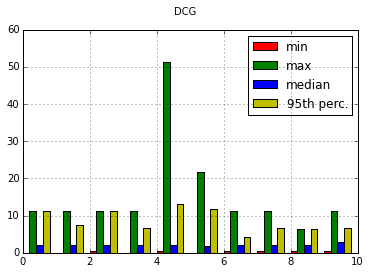

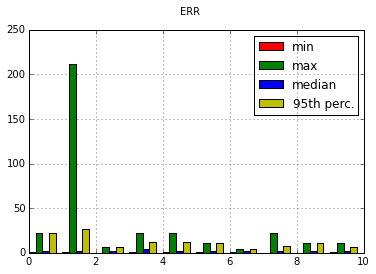

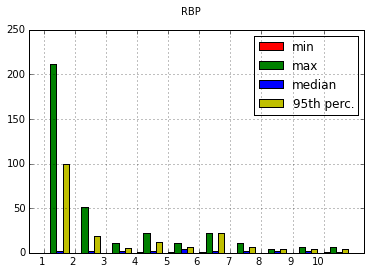

In [121]:
## test
stats=computeSampleStats()
plotStats(stats)

1. From the formula of the number of necessary samples, we can see that the more probabilities differ, the less samples we need. That makes sense, because if the difference between two observed samples is small, we need more samples to reject the null hypothesis with the set power. For example if alpha and beta are 0.05, and 0.1, respectively, and P_prob=0.45, E_prob=0.55 we need around 212 samples, but if E_prob is 0.7, we need only 11. From the plots we can see that in ERR and RBP this idea is supported, especially it’s visible for median, and maximum measures. On the other hand, this idea is less visible on DCG plot, it might be the case that evaluation has lower relation to the DCM we used to simulate experiments and therefore the plot looks more uniform. 

2. The significance test we use assumes that data is produced by gaussian distribution which is not always true, especially for real case data, and that makes the test less powerful and in some cases even false. In that case additional tests are used to verify that data is actually is coming from gaussian distribution. In our case we can’t conclude that this assumption is true for us, even those empirical studies indicate that in case of large numbers gaussian assumption is likely to be valid.  
In addition, we used sampling and not all data which also might produce skewed statistical results. This trade-off has been made to make computations faster. Moreover, data with relevance labels has been generated by an iterative algorithms, and usually this task is assigned to people. Therefore, tests could less meaningful when applied to synthetic data. Finally, in the computation of attractiveness parameter for DCGM we made an simplification assumption, which could be avoided and the more correct value obtained from the query logs as described in the book about click models.

3. Instead we could assume what is the expected difference in win probabilities, set the power, and the significance level and produce the necessary statistics (number of necessary samples). Or we could use query logs that were obtained from known to be very different ranking algorithms and produce necessary statistics based on logs instead of experiments. Alternatively, we could run an online experiment, e.g. with real users on interleaved SERP, and set the convergence condition to be the change in the win probabilities, i.e. if the delta probabilities does not vary over certain time, we finish the testing. 